Make it possible to import local modules

In [81]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

The OneMax problem is a canonical optimization problem in evolutionary learning. Given a bit string of a given length, the algorithm seeks to maximize its _fitness_ - which, in this context, is the sum of its digits. The _variator_ creates offspring by flipping each bit with a probability.

For a conrete example, the string
$$X=[1,1,0,0,0],$$
has a fitness of $2$ (for $1+1+0+0+0$). The variator then creates 2 children: $X'_1=[1,\color{red}0\color{defaultcolor},\color{green}1\color{defaultcolor},0,0]$ with fitness $2$ and $X'_2=[1,1,0,0,\color{green}1\color{defaultcolor}]$ with fitness $3$. The selector chooses $X'_2$, whose fitness is higher.

The _mutation rate_ - probability that each bit is flippped - is a parameter. The optimal value should be dynamic, and depend on the size of a string as well as the density of "1"s. For example, mutation rate for the string
$$[0,0,0,0,0]$$
should be as high as possible, because any change will result in a increase in fitness. This example does not use a dynamic parameter, however.

The optimal mutation rate has been found[^1].

[^1]: https://arxiv.org/abs/2006.11457

Code begins here. Start with importing core modules.

In [82]:
import typing
import random
from typing import TypeVar
from typing import Tuple
from typing import Optional
from core.controller import Controller
from core.evaluator import Evaluator
from core.population import Population
from core.population import Genome
from core.variator import Variator
from core.controller import Controller
from core.selector import Elitist
from core.selector import SimpleSelector
from core.selector import TournamentSelector


Declare exceptions for the learning process.

In [83]:
class IllegalVariation(Exception):
    def __init__(self):
        super().__init__("Given index out of bound!")

T = TypeVar('T', bound=Genome)

Declare the binary string representation `Binary` (a poor name), override necessary methods.

This is in fact [part of the framework](../evolvables/main.py), which is copied here verbatim. Once the representation is declared, the user can reuse it.

In [84]:
class Binary(Genome[T]):
    def __init__(self, len: int, value: typing.Optional[int] = None) -> None: 
        super().__init__()
        self.length = len
        if (value is None):
            self._value = 0
        else:
            self._value = value
    
    def _assert_index_is_valid(self, pos: int):
        if pos >= self.length:
            raise IllegalVariation

    def toggle(self, pos: int):
        self._assert_index_is_valid(pos)
        self._value = (self._value ^ (1 << (pos)))


    def __len__(self) -> int:
        return self.length
    
    @classmethod
    def create_random(cls, len:int) -> typing.Self:
        bin = cls(len)
        for i in range(0, len):
            if (bool(random.getrandbits(1))):
                bin.toggle(i)
        return bin

    @property
    def value(self):
        return self._value
    
    def copy(self) -> typing.Self:
        new_copy = self.__class__(self.length, self.value)
        return new_copy
    
    __deepcopy__ = copy
    __copy__ = copy

    def __str__(self):
        # return str(bin(self._value))[2:].ljust(self.length, '0')
        return str(bin(self._value))[2:].rjust(self.length, '0')

Then, declare the evaluator `BitDistanceEvaluator`. It simply sums the bits in a `Binary` string.

In [85]:
class BitDistanceEvaluator(Evaluator[Binary]):
    def evaluate(self, s1: Binary) -> float:
        return s1._value.bit_count()

Then, declare the variator `RandomBitMutator`. The name "mutator" means that the variator create offspring with only one parent. If more than one parent is used, then it becomes a _crossover operator_.

In [86]:
class RandomBitMutator(Variator[Binary]):
    def __init__ (self, mr = 0.001):
        super().__init__(1, 2)
        self.mr = mr

    def vary(self, parents: Tuple[Binary, ...], **kwargs) -> Tuple[Binary, ...]:
        binary = parents[0].copy()
        newbits = parents[0].copy()
        
        for i in range(0, len(binary)): # Somehow cannot properly implement the __len__ dunder 
            if (random.random()<self.mr):
                binary.toggle(i)
                newbits.toggle(i)
        return (binary, newbits)


Running the code is simple, once the necessary operators are declared.

Note how the population size goes up during the first few generations. The initial population has 10 items. The variator creates several children, while the selector enforces the population size limit of 100.

In [87]:
# Initialize population.
init_pop = Population[Binary]()

# The length of each bit string is 100.
REPR_LEN = 100

for i in range (0, 10):
    init_pop.append(Binary.create_random(100))

evaluator = BitDistanceEvaluator()
# The "elistst" wrapper maintains the best genome so far. It deposites that
#   genome into subsequent generations.
pselector = Elitist(SimpleSelector[Binary](1, 100))
cselector = Elitist(SimpleSelector[Binary](1, 100))
variator = RandomBitMutator(0.006)

ctrl = Controller[Binary] (
    population = init_pop,
    evaluator = evaluator,
    variator = variator,
    survivor_selector = pselector,
    parent_selector = cselector
)


Start the training process. During each iteration, record some data. Display that data.

In [88]:
dicts : typing.Dict[int, Optional[float]]= {}

for i in range(1, 101):
    ctrl.step()
    dicts[i] = {"population size" : len(ctrl.population),
                "best score" : ctrl.population[0].score,
                "worst score" : ctrl.population[-1].score}

from tabulate import tabulate

# Kludge a table for evolution process
plist = []
for i in dicts:
    plist.append([i] + list(dicts[i].values()))



print(tabulate(plist, headers=["generation"] + list(dicts[i].keys())))

  generation    population size    best score    worst score
------------  -----------------  ------------  -------------
           1                 23            55             44
           2                 49            57             44
           3                101            58             44
           4                101            58             50
           5                101            59             54
           6                101            60             56
           7                101            61             57
           8                101            61             58
           9                101            62             59
          10                101            63             60
          11                101            63             61
          12                101            65             61
          13                101            66             62
          14                101            66             63
          15            

Plot it.

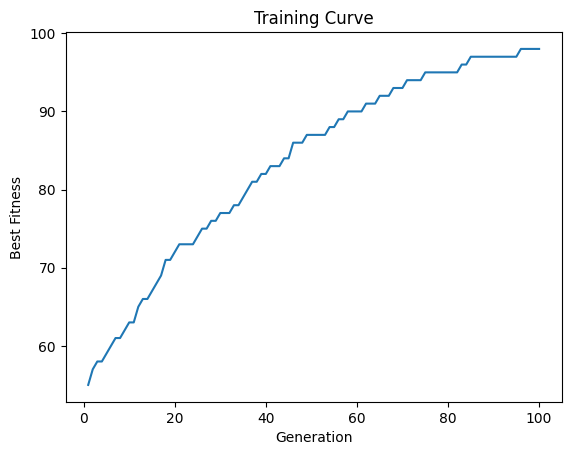

In [89]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in plist], [x[2] for x in plist])
plt.title("Training Curve")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.show()